In [1]:
#importing useful libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import zscore
import seaborn as sns
import mtgsdk

In [2]:
#load data
df=pd.read_csv("card-win-rates-2020-11-08.csv")

In [3]:
#look at just deck inclusions
deck=df.iloc[:,623:928]

#cleaning up the column names
new_col_names=[]
for name in deck.columns:
    new_col_names.append(name[5:])
deck.columns=new_col_names
deck

,Acquisitions Expert,Adventure Awaits,Agadeem's Awakening,"Agadeem, the Undercrypt","Akiri, Fearless Voyager",Akoum Hellhound,Akoum Teeth,Akoum Warrior,Allied Assault,Ancient Greenwarden,...,"Verazol, the Split Current",Veteran Adventurer,Vine Gecko,Wayward Guide-Beast,Windrider Wizard,"Yasharn, Implacable Earth","Zagras, Thief of Heartbeats","Zareth San, the Trickster",Zof Bloodbog,Zof Consumption
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86884,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
86885,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
86886,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
86887,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [4]:
#create a dictionary of cardname : color identity for deck classification
cards=mtgsdk.Card.where(set='znr').all()

In [5]:
color_ID={}
for card in cards:
    color_ID[card.name]=card.color_identity
for key in color_ID:
    print(key,color_ID[key])

Acquisitions Expert ['B']
Adventure Awaits ['G']
Agadeem, the Undercrypt ['B']
Agadeem's Awakening ['B']
Akiri, Fearless Voyager ['R', 'W']
Akoum Hellhound ['R']
Akoum Teeth ['R']
Akoum Warrior ['R']
Allied Assault ['W']
Ancient Greenwarden ['G']
Angel of Destiny ['W']
Angelheart Protector ['W']
Anticognition ['U']
Archon of Emeria ['W']
Archpriest of Iona ['W']
Ardent Electromancer ['R']
Ashaya, Soul of the Wild ['G']
Attended Healer ['W']
Bala Ged Sanctuary ['G']
Bala Ged Recovery ['G']
Base Camp []
Beyeen Coast ['U']
Beyeen Veil ['U']
Blackbloom Bog ['B']
Blackbloom Rogue ['B']
Blood Beckoning ['B']
Blood Price ['B']
Bloodchief's Thirst ['B']
Boulderloft Pathway ['G', 'W']
Branchloft Pathway ['G', 'W']
Grimclimb Pathway ['B', 'W']
Brightclimb Pathway ['B', 'W']
Broken Wings ['G']
Brushfire Elemental ['G', 'R']
Bubble Snare ['U']
Canopy Baloth ['G']
Canyon Jerboa ['W']
Cascade Seer ['U']
Charix, the Raging Isle ['U']
Chilling Trap ['U']
Cinderclasm ['R']
Cleansing Wildfire ['R']
Murk

In [6]:
#now looking at whether cards are land vs nonland
land={}
for card in cards:
    if 'Land' in card.type:
        land[card.name]=True
    else:
        land[card.name]=False
for key in land:
    print(key,land[key])

Acquisitions Expert False
Adventure Awaits False
Agadeem, the Undercrypt True
Agadeem's Awakening False
Akiri, Fearless Voyager False
Akoum Hellhound False
Akoum Teeth True
Akoum Warrior False
Allied Assault False
Ancient Greenwarden False
Angel of Destiny False
Angelheart Protector False
Anticognition False
Archon of Emeria False
Archpriest of Iona False
Ardent Electromancer False
Ashaya, Soul of the Wild False
Attended Healer False
Bala Ged Sanctuary True
Bala Ged Recovery False
Base Camp True
Beyeen Coast True
Beyeen Veil False
Blackbloom Bog True
Blackbloom Rogue False
Blood Beckoning False
Blood Price False
Bloodchief's Thirst False
Boulderloft Pathway True
Branchloft Pathway True
Grimclimb Pathway True
Brightclimb Pathway True
Broken Wings False
Brushfire Elemental False
Bubble Snare False
Canopy Baloth False
Canyon Jerboa False
Cascade Seer False
Charix, the Raging Isle False
Chilling Trap False
Cinderclasm False
Cleansing Wildfire False
Murkwater Pathway True
Clearwater Pathway

In [7]:
#creating a method that labels decks
def classify_deck (row,_allow_splash=True,_combine_splash=False):
    #use these to track land and card counts
    _red_lands=0
    _white_lands=0
    _blue_lands=0
    _green_lands=0
    _black_lands=0
    _red_cards=0
    _white_cards=0
    _blue_cards=0
    _green_cards=0
    _black_cards=0

    #determine land and card counts for each color in a deck
    for count,name in zip(row.values,row.index):
        if 'W' in color_ID[name]:
            if land[name]:
                _white_lands+=count
            else:
                _white_cards+=count
        if 'U' in color_ID[name]:
            if land[name]:
                _blue_lands+=count
            else:
                _blue_cards+=count
        if 'B' in color_ID[name]:
            if land[name]:
                _black_lands+=count
            else:
                _black_cards+=count
        if 'R' in color_ID[name]:
            if land[name]:
                _red_lands+=count
            else:
                _red_cards+=count
        if 'G' in color_ID[name]:
            if land[name]:
                _green_lands+=count
            else:
                _green_cards+=count
                
    #used to determine whether a color is missing, splashed, or main 1=splash 2=main
    #criteria from 17lands.com
    _W=0
    _U=0
    _B=0
    _R=0
    _G=0
    
    if _white_lands>0 and _white_cards>0:
        _W+=1
        if _white_lands>3 and _white_cards>3:
            _W+=1
    if _blue_lands>0 and _blue_cards>0:
        _U+=1
        if _blue_lands>3 and _blue_cards>3:
            _U+=1
    if _black_lands>0 and _black_cards>0:
        _B+=1
        if _black_lands>3 and _black_cards>3:
            _B+=1
    if _red_lands>0 and _red_cards>0:
        _R+=1
        if _red_lands>3 and _red_cards>3:
            _R+=1
    if _green_lands>0 and _green_cards>0:
        _G+=1
        if _green_lands>3 and _green_cards>3:
            _G+=1
      
    #assume jank as a default, manually assign all 1, 2, and 3 color combinations
    _deck_type="Jank"
    if _W==2:
        if _U==2:
            if (_B+_R+_G)==1:
                if _allow_splash:
                    _deck_type="WU+Splash"
                elif _combine_splash:
                    _deck_type="WU"
            elif (_B+_R+_G)==0:
                _deck_type="WU"
            elif _B==2 and _R+_G==0:
                _deck_type="WUB"
            elif _B==2 and _R+_G==1:
                if _allow_splash:
                    _deck_type="WUB+Splash"
                elif _combine_splash:
                    _deck_type="WUB"
            elif _R==2 and _B+_G==0:
                _deck_type="WUR"
            elif _R==2 and _B+_G==1:
                if _allow_splash:
                    _deck_type="WUR+Splash"
                elif _combine_splash:
                    _deck_type="WUR"
            elif _G==2 and _B+_R==0:
                _deck_type="WUG"
            elif _G==2 and _B+_R==1:
                if _allow_splash:
                    _deck_type="WUG+Splash"
                elif _combine_splash:
                    _deck_type="WUG"
        elif _B==2:
            if (_U+_R+_G)==1:
                if _allow_splash:
                    _deck_type="WB+Splash"
                elif _combine_splash:
                    _deck_type="WB"
            elif (_U+_R+_G)==0:
                _deck_type="WB"
            elif _R==2 and _U+_G==0:
                _deck_type="WBR"
            elif _R==2 and _U+_G==1:
                if _allow_splash:
                    _deck_type="WBR+Splash"
                elif _combine_splash:
                    _deck_type="WBR"
            elif _G==2 and _U+_R==0:
                _deck_type="WBG"
            elif _G==2 and _U+_R==1:
                if _allow_splash:
                    _deck_type="WBG+Splash"
                elif _combine_splash:
                    _deck_type="WBG"
        elif _R==2:
            if (_U+_B+_G)==1:
                if _allow_splash:
                    _deck_type="WR+Splash"
                elif _combine_splash:
                    _deck_type="WR"
            elif (_U+_B+_G)==0:
                _deck_type="WR"
            elif _G==2 and _U+_B==0:
                _deck_type="WRG"
            elif _G==2 and _U+_B==1:
                if _allow_splash:
                    _deck_type="WRG+Splash"
                elif _combine_splash:
                    _deck_type="WRG"
        elif _G==2:
            if (_U+_B+_R)==1:
                if _allow_splash:
                    _deck_type="WG+Splash"
                elif _combine_splash:
                    _deck_type="WG"
            elif (_U+_B+_R)==0:
                _deck_type="WG"
        elif _U+_B+_R+_G>=1:
            if _allow_splash:
                _deck_type="MonoW+Splash"
            elif _combine_splash:
                _deck_type="MonoW"
        elif _U+_B+_R+_G==0:
            _deck_type="MonoW"
    elif _U==2:
        if _B==2:
            if (_W+_R+_G)==1:
                if _allow_splash:
                    _deck_type="UB+Splash"
                elif _combine_splash:
                    _deck_type="UB"
            elif (_W+_R+_G)==0:
                _deck_type="UB"
            elif _R==2 and _G+_W==0:
                _deck_type="UBR"
            elif _R==2 and _G+_W==1:
                if _allow_splash:
                    _deck_type="UBR+Splash"
                elif _combine_splash:
                    _deck_type="UBR"
            elif _G==2 and _R+_W==0:
                _deck_type="UBG"
            elif _G==2 and _R+_W==1:
                if _allow_splash:
                    _deck_type="UBG+Splash"
                elif _combine_splash:
                    _deck_type="UBG"
        elif _R==2:
            if (_W+_B+_G)==1:
                if _allow_splash:
                    _deck_type="UR+Splash"
                elif _combine_splash:
                    _deck_type="UR"
            elif (_W+_B+_G)==0:
                _deck_type="UR"
            elif _G==2 and _B+_W==0:
                _deck_type="URG"
            elif _G==2 and _B+_W==1:
                if _allow_splash:
                    _deck_type="URG+Splash"
                elif _combine_splash:
                    _deck_type="URG"
        elif _G==2:
            if (_W+_B+_R)==1:
                if _allow_splash:
                    _deck_type="UG+Splash"
                elif _combine_splash:
                    _deck_type="UG"
            elif (_W+_B+_R)==0:
                _deck_type="UG"
        elif _W+_B+_R+_G>=1:
            if _allow_splash:
                _deck_type="MonoU+Splash"
            elif _combine_splash:
                _deck_type="MonoU"
        elif _W+_B+_R+_G==0:
            _deck_type="MonoU"
    elif _B==2:
        if _R==2:
            if (_W+_U+_G)==1:
                if _allow_splash:
                    _deck_type="BR+Splash"
                elif _combine_splash:
                    _deck_type="BR"
            elif (_W+_U+_G)==0:
                _deck_type="BR"
            elif _G==2 and _W+_U==0:
                _deck_type="BRG"
            elif _G==2 and _W+_U==1:
                if _allow_splash:
                    _deck_type="BRG+Splash"
                elif _combine_splash:
                    _deck_type="BRG"
        elif _G==2:
            if (_W+_U+_R)==1:
                if _allow_splash:
                    _deck_type="BG+Splash"
                elif _combine_splash:
                    _deck_type="BG"
            elif (_W+_U+_R)==0:
                _deck_type="BG"
        elif _W+_U+_R+_G>=1:
            if _allow_splash:
                _deck_type="MonoB+Splash"
            elif _combine_splash:
                _deck_type="MonoB"
        elif _W+_U+_R+_G==0:
            _deck_type="MonoB"
    elif _R==2:
        if _G==2:
            if (_W+_U+_B)==1:
                if _allow_splash:
                    _deck_type="RG+Splash"
                elif _combine_splash:
                    _deck_type="RG"
            elif (_W+_U+_B)==0:
                _deck_type="RG"
        elif _W+_U+_B+_G>=1:
            if _allow_splash:
                _deck_type="MonoR+Splash"
            elif _combine_splash:
                _deck_type="MonoR"
        elif _W+_U+_B+_G==0:
            _deck_type="MonoR"
    elif _G==2:
        if _W+_U+_B+_R>=1:
            if _allow_splash:
                _deck_type="MonoG+Splash"
            elif _combine_splash:
                _deck_type="MonoG"
        elif _W+_U+_B+_R==0:
            _deck_type="MonoG"
            
            
                
    return _deck_type
        
            
                
        
            
cluster_names=deck.apply(lambda row: classify_deck(row,_allow_splash=False,_combine_splash=True), axis=1)

In [8]:
cluster_names.value_counts()

WB       11794
UB       11060
UG       11051
UR       10857
WR       10821
BR       10528
RG        4765
WU        4739
BG        4365
WG        3297
Jank       727
MonoU      605
MonoR      373
MonoG      328
WUB        246
URG        206
WRG        161
WBR        154
UBG        153
WBG        138
MonoB      125
UBR        118
BRG        104
WUG         68
WUR         53
MonoW       53
dtype: int64

In [9]:
#applying the names
deck['deck_type']=cluster_names
#need to add whether or not the deck won into the decklist
deck['won']=df['won']
#checking
deck.head()

,Acquisitions Expert,Adventure Awaits,Agadeem's Awakening,"Agadeem, the Undercrypt","Akiri, Fearless Voyager",Akoum Hellhound,Akoum Teeth,Akoum Warrior,Allied Assault,Ancient Greenwarden,...,Vine Gecko,Wayward Guide-Beast,Windrider Wizard,"Yasharn, Implacable Earth","Zagras, Thief of Heartbeats","Zareth San, the Trickster",Zof Bloodbog,Zof Consumption,deck_type,won
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,BR,False
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,BR,True
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,BR,False
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,BR,True
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,BR,False


In [10]:
#selecting just 2 color combinations
list_of_decks=['WB','UB','UR','WR','BR','UG','WU','RG','BG','WG']
# can also including mono colors. Just uncomment the code below
# list_of_decks=list_of_decks+['MonoW','MonoU','MonoB','MonoR','MonoG']
list_of_decks

['WB', 'UB', 'UR', 'WR', 'BR', 'UG', 'WU', 'RG', 'BG', 'WG']

In [31]:
#This cell will separate out each of the listed decks, z-score the cards included by deck, separate winning and losing
#decks, then subtract the losses from the wins. Finally it will create a dataframe of results

#use this to store results
results_list=[]
#can change how many samples you need to include a splash
min_samples=10

for i,archetype in enumerate(list_of_decks):
    #grab only the selected deck
    temp_deck=deck[deck['deck_type']==archetype]
    #check each column. Remember all but the last two columns are specific cards
    for col in temp_deck.columns[:-2]: 
        #assume a default of the card isn't splashed
        _splash=False
        #check each color in the color identity
        for color in color_ID[col]:
            #if any color in the color identity doesn't match the archetype mark it as a splash
            if color not in archetype:
                _splash=True
        #removing lands from splashes could be left in as well
        if land[col]:
            _splash=False
        #removing all cards that aren't splashes to leave only splashes
        if not _splash:
            temp_deck[col].values[:]=0
            
    #apply z-score to all but 'won' and 'deck_name'
    #first find the indexes of wins and losses
    win_idx=temp_deck['won']==True
    loss_idx=temp_deck['won']==False
    #apply z-score to the dataframe dropping the deck type and won/loss result
    temp_deck=temp_deck.drop(columns=['won','deck_type']).apply(zscore)
    #separate wins and losses
    temp_wins=temp_deck[win_idx]
    temp_losses=temp_deck[loss_idx]
    #subtract the z-scores of losses from wins.
    diff=temp_wins.mean(axis=0)-temp_losses.mean(axis=0)
    
    #now checking to see if enough samples exist
    #use this to store count of unique decks
    unique_decks=[]
    #check each card in this color combination
    for card in temp_deck.columns:
        #remove multiple instances of the same deck, eg. a 7-2 deck shows up 9 times
        temp_deck_2=temp_deck.drop_duplicates()
        #get the count of decks that contain the card
        unique_decks.append(temp_deck_2[temp_deck_2[card]>0].shape[0])
    #check the number of unique decks that contain the card. If it's less than the threshold, change the corresponding
    #z-score difference to NaN so it isn't included
    for j,deck_count in enumerate(unique_decks):
        if deck_count < min_samples:
            diff[j]='NaN'
    
    #store the result
    results_list.append(diff)
#make the result a dataframe
results=pd.DataFrame(results_list)
#add the deck name in and set it as index
results['deck']=pd.Series(list_of_decks)
results=results.set_index('deck')
#drop any rows of all missing values. Necessary for MDCs
results=results.dropna(axis=1,how="all")
#round the z-scores to 3 decimal places
results=results.round(3)


C:\Users\gamui\anaconda3\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
C:\Users\gamui\anaconda3\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
C:\Users\gamui\anaconda3\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
C:\Users\gamui\anaconda3\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
C:\Users\gamui\anaconda3\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
C:\Users\gamui\anaconda3\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
C:\Users\gamui\anaconda3\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarni

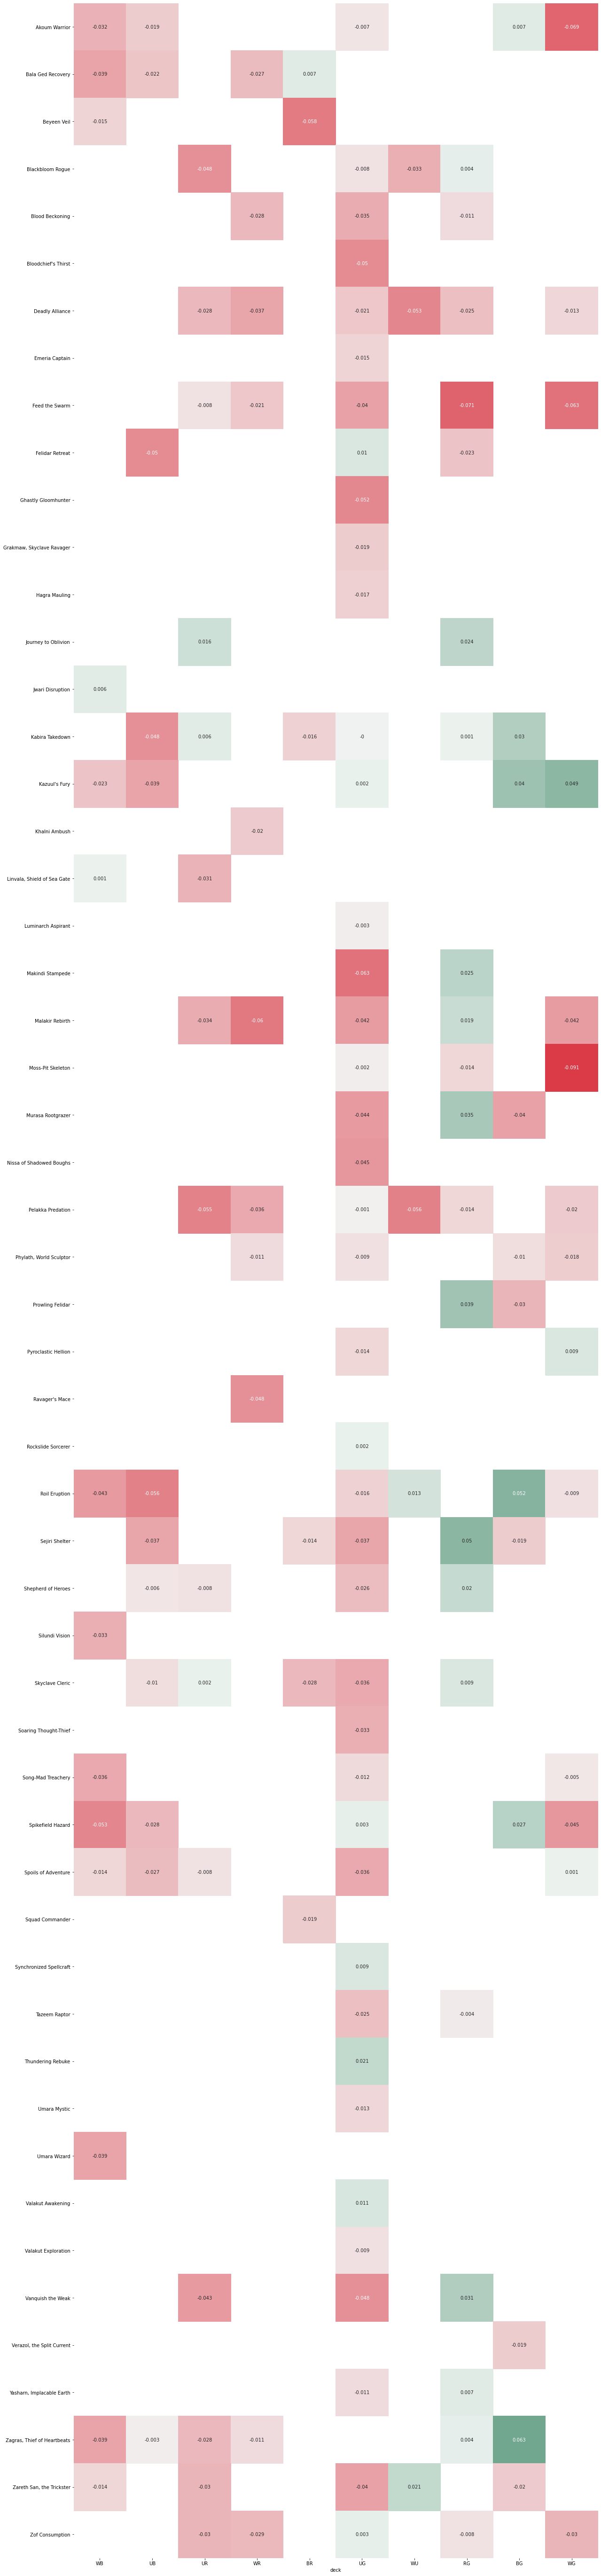

In [33]:
#Do some visualizations

#first set the figuresize to be appropriate
plt.rcParams["figure.figsize"] = (20,100)

#create a red-green diverging color palette
cm = sns.diverging_palette(10, 150, as_cmap=True)
#transpose the dataframe and apply the styling. Save to excel



s = results.T.style.background_gradient(cmap=cm)
s.to_excel("ZNR_splash.xlsx")

#create a heatmap and save the figure to .png
hmap=sns.heatmap(results.T,cmap=cm,center=0,annot=True,cbar=False)
figure=hmap.get_figure()
figure.savefig('ZNR_splash.png')
plt.show()